In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
%matplotlib inline

In [3]:
conn = psycopg2.connect(database="dreamteam_csgodb", user="postgres", password="p0stgr3s", host="localhost", port="5432")
cur = conn.cursor()

### Top ten ranked countries

In [43]:
cur.execute('''SELECT d.name, avg(c.rating) country_rate, sum(c.num_rates) num_rates
                FROM core.users a, core.profiles b, games.profiles_ratings c, data.countries d
                WHERE a.id=b.user_id and b.id=c.profile_id and a.country=d.code
                GROUP BY d.name
                ORDER BY country_rate desc''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
country_ranks_df = pd.DataFrame(rows, columns = col_names)

Text(0,0.5,'Average rate')

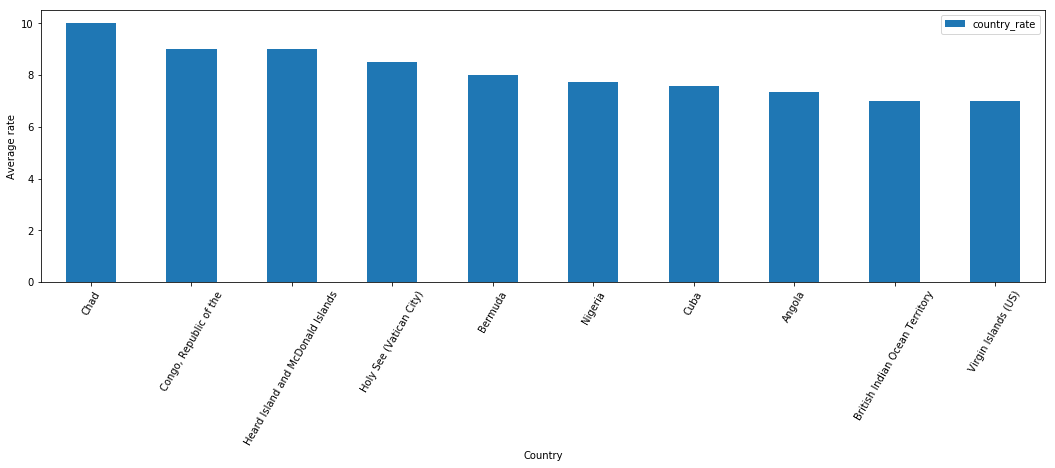

In [53]:
top10 = country_ranks_df.head(10)
top10.set_index(["name"],inplace=True)
top10.plot(y=['country_rate'], kind='bar', rot=60, figsize=(18, 5))
plt.xlabel("Country")
plt.ylabel("Average rate")

In [56]:
cur.execute('''SELECT f.name, avg(c.rating) region_rate, sum(c.num_rates) num_rates
               FROM core.users a, core.profiles b, games.profiles_ratings c, data.countries d, 
                    data.regions_countries e, data.regions f
               WHERE a.id=b.user_id and b.id=c.profile_id and a.country=d.code and d.code=e.country and 
                     f.id=e.region_id
               GROUP BY f.name
               ORDER BY region_rate desc''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
region_ranks_df = pd.DataFrame(rows, columns = col_names)

Text(0,0.5,'Average rate')

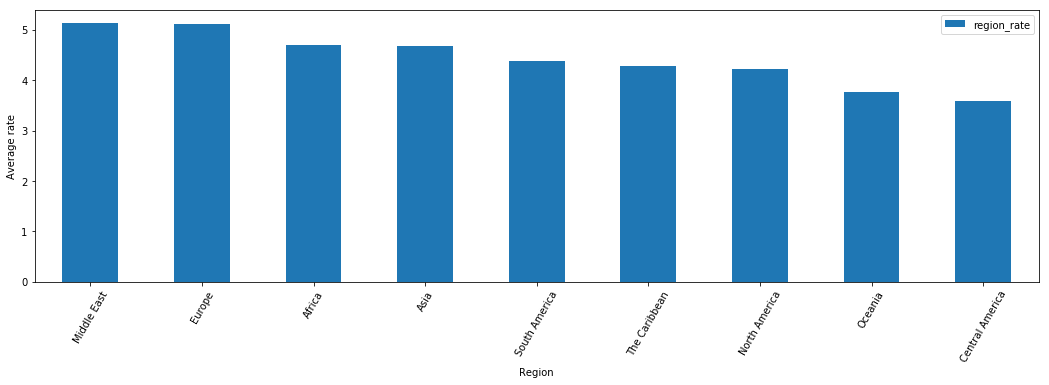

In [57]:
region_ranks_df.set_index(["name"],inplace=True)
region_ranks_df.plot(y=['region_rate'], kind='bar', rot=60, figsize=(18, 5))
plt.xlabel("Region")
plt.ylabel("Average rate")

### Correlations between players, maps and weapons statistics

In [7]:
cur.execute('''SELECT date_part('year',age(a.birthday)) age, 
                      CASE 
                        WHEN (a.gender='m') THEN 1
                        WHEN (a.gender='f') THEN 2
                        ELSE 0
                      END AS gender, e.country_id, f.rating, g.total_kills, 
                      g.total_time_played, g.total_deaths, g.total_kills_headshot, g.total_shots_hit, g.total_mvps, 
                      g.total_wins, g.total_rounds_played, g.total_shots_fired, g.rank_id, g.goal_id, 
                      h.map_total_rounds, h.map_total_wins
               FROM core.users a
               INNER JOIN core.profiles b ON a.id=b.user_id
               INNER JOIN games.profiles_roles c ON b.id=c.profile_id
               INNER JOIN games.roles d ON c.role_id=d.id
               INNER JOIN (SELECT ROW_NUMBER() OVER (ORDER BY 1) AS country_id, * from data.countries) e ON a.country=e.code
               INNER JOIN games.profiles_ratings f ON b.id=f.profile_id
               INNER JOIN csgo.profiles g ON a.id=g.user_id
               INNER JOIN (SELECT user_id, sum(total_rounds) AS map_total_rounds, sum(total_wins) as map_total_wins
                           FROM csgo.maps_stats
                           GROUP BY user_id) h ON g.user_id=h.user_id
                  WHERE d.name = 'sniper'
                        AND g.total_kills_headshot IS NOT NULL
                        AND g.total_kills / 9 <= h.map_total_rounds
                        AND g.total_kills_headshot <= g.total_kills
                        AND g.total_kills_headshot < 4000000''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
csgo_players_df = pd.DataFrame(rows, columns = col_names)

In [8]:
print(csgo_players_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41043 entries, 0 to 41042
Data columns (total 17 columns):
age                     41043 non-null float64
gender                  41043 non-null int64
country_id              41043 non-null int64
rating                  41043 non-null float64
total_kills             41043 non-null int64
total_time_played       41043 non-null int64
total_deaths            41041 non-null float64
total_kills_headshot    41043 non-null int64
total_shots_hit         41043 non-null int64
total_mvps              41026 non-null float64
total_wins              41043 non-null int64
total_rounds_played     41043 non-null int64
total_shots_fired       41043 non-null int64
rank_id                 41043 non-null int64
goal_id                 41043 non-null int64
map_total_rounds        41043 non-null int64
map_total_wins          41043 non-null int64
dtypes: float64(4), int64(13)
memory usage: 5.3 MB
None


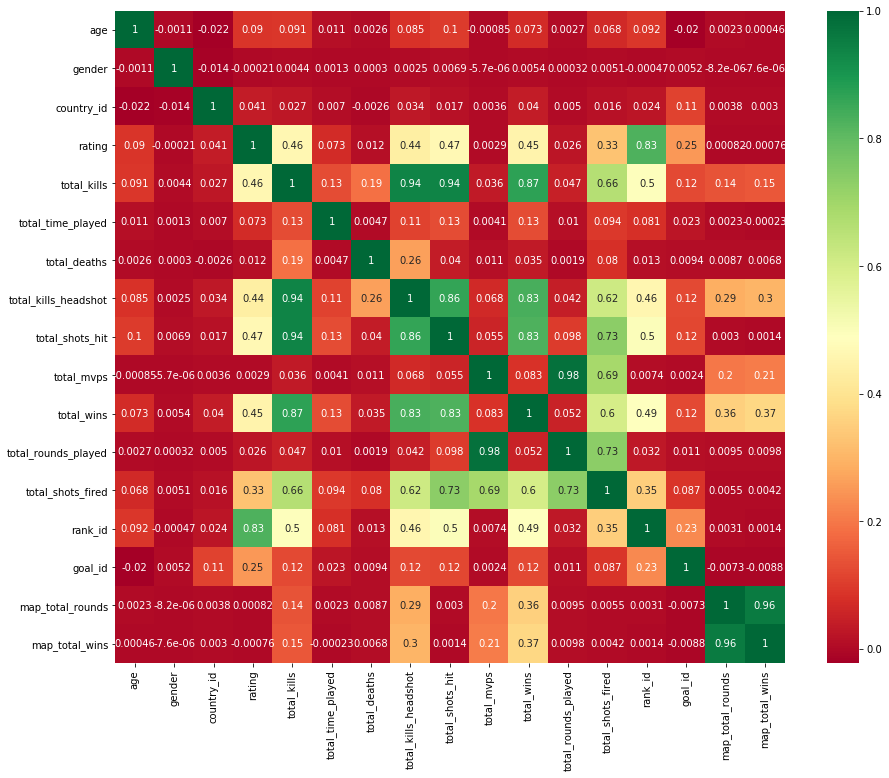

In [9]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(csgo_players_df.corr(), annot=True, cbar=True, cmap="RdYlGn")

From the above heat map the most interesting correlations, and likely causations are:
- Total shots hit <--> total shots fired
- Total kills headshots --> total wins
- Total kills --> total wins
- Total rounds played --> total mvps

### Analyzing correlations between age/country and weapons usage

In [69]:
cur.execute('''SELECT date_part('year',age(a.birthday)) age, b.weapon_id, c.total_kills, c.total_hits, c.total_shots
               FROM core.users a, 
                    (SELECT ROW_NUMBER() OVER (ORDER BY 1) AS weapon_id, * from csgo.weapons) b, 
                    csgo.weapons_stats c
               WHERE b.name=c.weapon_name and a.id = c.user_id''')
rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
age_weapons_stats = pd.DataFrame(rows, columns = col_names)

cur.execute('''SELECT b.region_id, c.weapon_name, c.total_kills, c.total_hits, c.total_shots
               FROM core.users a 
               INNER JOIN data.regions_countries b on a.country=b.country
               INNER JOIN csgo.weapons_stats c on a.id = c.user_id''')
rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
country_weapons_stats = pd.DataFrame(rows, columns = col_names)

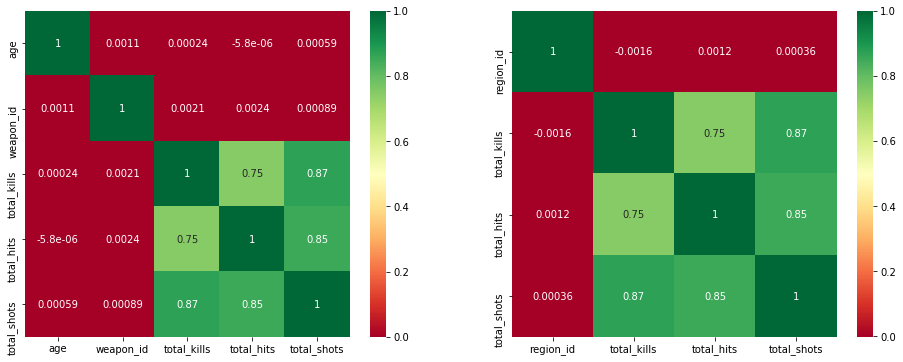

In [70]:
f = plt.figure(figsize=(16, 6))

ax = f.add_subplot(1, 2, 1, label='plot1')
sns.heatmap(age_weapons_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

ax = f.add_subplot(1, 2, 2, label='plot2')
sns.heatmap(country_weapons_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

### Analyzing correlations between age/country and map statistics

In [71]:
cur.execute('''SELECT date_part('year',age(a.birthday)) age, c.total_rounds, c.total_wins, b.map_id
               FROM core.users a,
                    (SELECT DISTINCT map_name, DENSE_RANK() OVER (ORDER BY map_name) map_id
                     FROM csgo.maps_stats
                     ORDER BY map_name, map_id) b,
                    csgo.maps_stats c
               WHERE b.map_name=c.map_name and a.id = c.user_id''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
age_map_stats = pd.DataFrame(rows, columns = col_names)

cur.execute('''SELECT b.region_id, c.total_rounds, c.total_wins, d.map_id
               FROM core.users a,
                    data.regions_countries b,
                    csgo.maps_stats c,
                    (SELECT DISTINCT map_name, DENSE_RANK() OVER (ORDER BY map_name) map_id
                     FROM csgo.maps_stats
                     ORDER BY map_name, map_id) d
               WHERE a.id = c.user_id and a.country=b.country and d.map_name=c.map_name and a.id = c.user_id''')
rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
country_map_stats = pd.DataFrame(rows, columns = col_names)

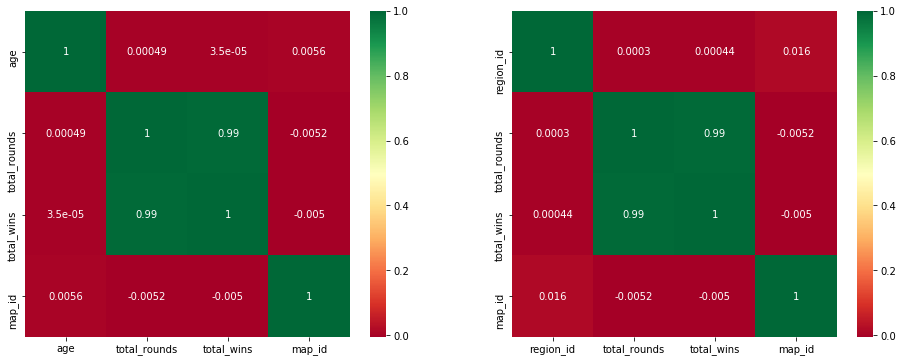

In [72]:
f = plt.figure(figsize=(16, 6))

ax = f.add_subplot(1, 2, 1, label='plot1')
sns.heatmap(age_map_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

ax = f.add_subplot(1, 2, 2, label='plot2')
sns.heatmap(country_map_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")